In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.cluster import KMeans
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

"""
First we will import the necessary libraries for our analysis.
We might also need some functions from our main.py file
"""
import main


In [17]:
# Let's first get the datasets and split them
joke_dataset, train_dataset_full, train_dataset, val_dataset, test_dataset = main.load_and_split_data()

# This will split the dataset up into training and test sets and create the necessary input/output pairs
selected_indices, complement_indices, JTrain_x, JTrain_y, JTest_x, JTest_y = main.select_train_complement_indices(
        joke_dataset, train_dataset_full, train_dataset, val_dataset, test_dataset, cross_validation=True)




In [ ]:
# Now let's create a cross-validation routine

import time

def cross_validate_model(data, selected_indices, complement_indices, n_splits=5):
    """
    Perform k-fold cross-validation on the dataset.
    
    Parameters:
    data (numpy.ndarray): Full dataset.
    selected_indices (list): Indices of selected features.
    complement_indices (list): Indices of complementary features.
    k (int): Number of components for dimensionality reduction.
    n_splits (int): Number of folds for cross-validation.
    
    Returns:
    avg_model (numpy.ndarray): Averaged model parameters across all folds.
    avg_train_error (float): Average relative error on training sets across all folds.
    avg_val_error (float): Average relative error on validation sets across all folds.
    avg_loss_training (float): Average loss on training sets across all folds.
    avg_loss_validation (float): Average loss on validation sets across all folds.
    """

    k = 2

    normalization_factor = 1/10 
    data = data * normalization_factor # Normalize the data to be between 0 and 1

    kfold = KFold(n_splits=n_splits)

    all_relative_errors_training = []
    all_relative_errors_validation = []
    all_loss_training = []
    all_loss_validation = []
    all_models = []

    for train_index, val_index in kfold.split(data):



        X_train, X_val = data[train_index], data[val_index]
        JTrain_x = X_train[:, selected_indices]
        JTrain_y = X_train[:, complement_indices]
        JDev_x = X_val[:, selected_indices]
        JDev_y = X_val[:, complement_indices]

        mu_x = np.mean(JTrain_x, axis=0)
        X_train_centered = JTrain_x - mu_x
        X_val_centered = JDev_x - mu_x


        U, S, V_T = np.linalg.svd(JTrain_x, full_matrices=False)
        U_k = U[:, :k]
        S_k = np.diag(S[:k])
        V_T_k = V_T[:k, :]

        xtrain_reduced = X_train_centered @ V_T_k.T
        xtrain_reduced = np.hstack((xtrain_reduced, np.ones((xtrain_reduced.shape[0], 1))))  # Add bias term
        x_dev_reduced = X_val_centered @ V_T_k.T
        x_dev_reduced = np.hstack((x_dev_reduced, np.ones((x_dev_reduced.shape[0], 1))))  # Add bias term

        model = keras.Sequential([
            keras.layers.Input(shape=(xtrain_reduced.shape[1],)),
            keras.layers.Dense(16, activation="relu"), #kernel_regularizer=keras.regularizers.l2(1e-3)), #what does this do?
            keras.layers.Dense(JTrain_y.shape[1], activation="linear")
        ])

        model.compile(optimizer="adam",
                       loss="mse", metrics=["mae"])


        model.fit(
            xtrain_reduced, JTrain_y,
            validation_data=(x_dev_reduced, JDev_y),
            epochs=30,
            batch_size=8,   # smaller batch size helps with tiny datasets
            callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
        )


        # time_start = time.time()
        # model.fit(xtrain_reduced, JTrain_y, epochs=5, batch_size=32)
        # time_end = time.time()
        # print(f"Training time: {time_end - time_start} seconds")

        all_models.append(model)
        print(f'train rel error: {np.linalg.norm(model.predict(xtrain_reduced) - JTrain_y, "fro") / np.linalg.norm(JTrain_y, "fro")}')
        all_relative_errors_training.append(np.linalg.norm(model.predict(xtrain_reduced) - JTrain_y, "fro") / np.linalg.norm(JTrain_y, "fro"))
        all_relative_errors_validation.append(np.linalg.norm(model.predict(x_dev_reduced) - JDev_y, "fro") / np.linalg.norm(JDev_y, "fro"))
        print(f'val rel error: {np.linalg.norm(model.predict(x_dev_reduced) - JDev_y, "fro") / np.linalg.norm(JDev_y, "fro")}')
        all_loss_training.append(np.mean(model.evaluate(xtrain_reduced, JTrain_y)))
        all_loss_validation.append(np.mean(model.evaluate(x_dev_reduced, JDev_y)))

        dev_predictions = model.predict(x_dev_reduced)
        dev_residuals = dev_predictions - JDev_y
        train_predictions = model.predict(xtrain_reduced)
        train_residuals = train_predictions - JTrain_y
        print(f'train residuals: {np.linalg.norm(train_residuals, "fro") / np.linalg.norm(JTrain_y, "fro")}')
        print(f'dev residuals: {np.linalg.norm(dev_residuals, "fro") / np.linalg.norm(JDev_y, "fro")}')
        print('\n')


    #create a plot of a random in the training set
    
    random_index = np.random.randint(0, 26)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Training Set Predictions")
    plt.scatter(np.arange(0, len(JTrain_y)), JTrain_y[:, random_index], label="True", alpha=0.5)
    plt.scatter(np.arange(0, len(JTrain_y)), model.predict(xtrain_reduced)[:, random_index], label="Predicted", alpha=0.5)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("Validation Set Predictions")
    plt.scatter(np.arange(len(JDev_y)), JDev_y[:, random_index], label="True", alpha=0.5)
    plt.scatter(np.arange(len(JDev_y)), model.predict(x_dev_reduced)[:, random_index], label="Predicted", alpha=0.5)
    plt.legend()

    plt.show()

    #avg_model = np.mean(all_models, axis=0)  # Averaging models might not be the best idea in either NN or Linear model since the model could be converging to two different local minima in the objective function space
    avg_train_error = -1 #np.mean(all_relative_errors_training)
    avg_val_error = -1 #np.mean(all_relative_errors_validation)
    avg_loss_training = np.mean(all_loss_training,axis=0)
    avg_loss_validation = np.mean(all_loss_validation,axis=0)

    print(f'predictive dev set:{model.predict(x_dev_reduced)[:, random_index]}')
    print(f'actual dev set:{JDev_y[:, random_index]}')

    print(f'sample predictive train set:{model.predict(xtrain_reduced)[:, random_index]}')
    print(f'sample actual train set:{JTrain_y[:, random_index]}')

    return all_models, all_relative_errors_training, all_relative_errors_validation, all_loss_training, all_loss_validation, avg_train_error, avg_val_error, avg_loss_training, avg_loss_validation

######################
    all_relative_errors_training = []
    all_relative_errors_validation = []
    all_models = []

    for train_index, val_index in kfold.split(data):
        X_train, X_val = data[train_index], data[val_index]

        JTrain_x = X_train[:, selected_indices]
        JTrain_y = X_train[:, complement_indices]
        JDev_x = X_val[:, selected_indices]
        JDev_y = X_val[:, complement_indices]

        model = train_model(JTrain_x, JTrain_y, k)
        train_relative_error = evaluate_model(model, JTrain_x, JTrain_y)
        val_relative_error = evaluate_model(model, JDev_x, JDev_y)

        all_models.append(model)
        all_relative_errors_training.append(train_relative_error)
        all_relative_errors_validation.append(val_relative_error)

    avg_model = np.mean(all_models, axis=0)  # Average model coefficients
    avg_train_error = np.mean(all_relative_errors_training)
    avg_val_error = np.mean(all_relative_errors_validation)

    return avg_model, avg_train_error, avg_val_error

# Now we can run the cross-validation routine first with n_splits=10
all_models, all_relative_errors_training, all_relative_errors_validation, all_loss_training, all_loss_validation, avg_train_error, avg_val_error, avg_loss_training, avg_loss_validation = cross_validate_model(train_dataset_full, selected_indices, complement_indices, n_splits=10)


Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.3604 - mae: 0.5070 - val_loss: 0.3279 - val_mae: 0.4571
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3394 - mae: 0.4851 - val_loss: 0.3145 - val_mae: 0.4470
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3104 - mae: 0.4735 - val_loss: 0.3025 - val_mae: 0.4378
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3217 - mae: 0.4767 - val_loss: 0.2911 - val_mae: 0.4291
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2839 - mae: 0.4511 - val_loss: 0.2804 - val_mae: 0.4209
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2853 - mae: 0.4519 - val_loss: 0.2702 - val_mae: 0.4128
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2818 - mae: 0.4447 - val_loss: 0.2605 - val_mae: 0.4049
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2600 - mae: 0.4258 - val_loss: 0.2512 - val_mae: 0.3971
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2563 - mae: 0.4225 - 

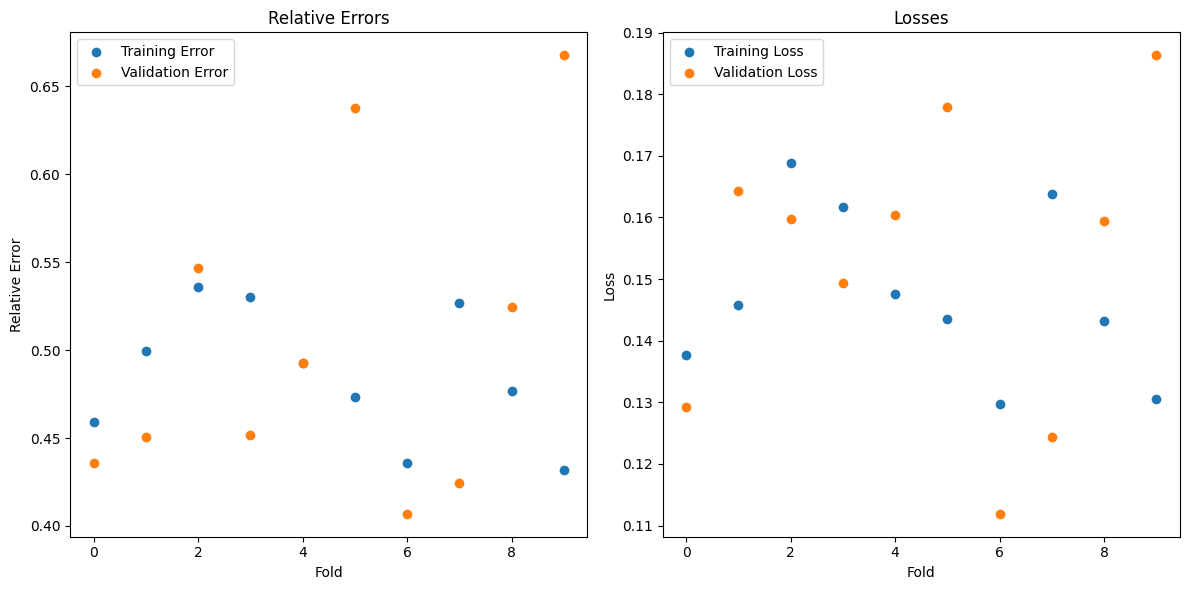

[[2.]
 [2.]
 [2.]]


In [20]:
# Let's plot some results

import matplotlib.pyplot as plt

fold_number = np.arange(0, len(all_relative_errors_training))
# Plot training and validation errors
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(fold_number, all_relative_errors_training, label='Training Error')
plt.scatter(fold_number, all_relative_errors_validation, label='Validation Error')
plt.title('Relative Errors')
plt.xlabel('Fold')
plt.ylabel('Relative Error')
plt.legend()

# Plot training and validation losses
plt.subplot(1, 2, 2)
plt.scatter(fold_number, all_loss_training, label='Training Loss')
plt.scatter(fold_number, all_loss_validation, label='Validation Loss')
plt.title('Losses')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(np.ones((3, 1))*2)